Import Libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ModuleNotFoundError: No module named 'nltk'

Load Dataset

In [225]:
from google.colab import drive

drive.mount('/content/drive')

train_path = '/content/drive/My Drive/phm/phm_train.csv'
test_path = '/content/drive/My Drive/phm/phm_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print("\nTrain Data Head:")
print(train_data.head())
print("\nTest Data Head:")
print(test_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Train Data Head:
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...

Test Data Head:
       tweet_id  label                                              tweet
0  6.410000e+17      0  when you try to run away from the iv needle so...
1  6.430000e+17      1  i just knew i took an ambien for sleep too ear...
2  6.410000e+17      1  i mean i get that my celexa is the reason behi...
3  7.480000e+17      0  if you call me dumb or her dumb one more time ...
4  6.410000e+17      0

Declare Stopwords

In [226]:
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Preprocessing and Encoding Labels

In [227]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in english_stops])
    return text

train_data['cleaned_text'] = train_data['tweet'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['tweet'].apply(preprocess_text)

x_train = train_data['cleaned_text']
y_train = train_data['label']
x_test = test_data['cleaned_text']
y_test = test_data['label']

Tokenization and Padding

In [228]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

def get_max_length():
    review_length = []
    for review in x_train_seq:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))

max_length = get_max_length()

x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

total_words = len(tokenizer.word_index) + 1

print("\nMaximum sequence length:", max_length)
print("Total words in vocabulary:", total_words)


Maximum sequence length: 10
Total words in vocabulary: 12726


Build the LSTM Model

In [229]:
EMBED_DIM = 128
LSTM_OUT = 64

lstm_model = Sequential()
lstm_model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
lstm_model.add(LSTM(LSTM_OUT))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Build the Bi-LSTM Model

In [230]:
EMBED_DIM = 128
LSTM_OUT = 64

bilstm_model = Sequential()
bilstm_model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
bilstm_model.add(Bidirectional(LSTM(LSTM_OUT)))
bilstm_model.add(Dense(1, activation='sigmoid'))
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Callbacks

In [231]:
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

Train the LSTM Model

In [232]:
lstm_history = lstm_model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=5,
    batch_size=128,
    callbacks=[model_checkpoint]
)

print(lstm_model.summary())

Epoch 1/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7194 - loss: 0.5918

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7203 - loss: 0.5902 - val_accuracy: 0.8139 - val_loss: 0.4050
Epoch 2/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8582 - loss: 0.3329

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8581 - loss: 0.3329 - val_accuracy: 0.8274 - val_loss: 0.4006
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9080 - loss: 0.2363 - val_accuracy: 0.8202 - val_loss: 0.4656
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9318 - loss: 0.1786 - val_accuracy: 0.8142 - val_loss: 0.5144
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9489 - loss: 0.1481 - val_accuracy: 0.8082 - val_loss: 0.5926


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_49 (Embedding)        │ (None, 10, 128)        │     1,628,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,035,205 (19.21 MB)

 Trainable params: 1,678,401 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,356,804 (12.81 MB)

None


Train the Bi-LSTM Model

In [233]:
bilstm_history = bilstm_model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=5,
    batch_size=128,
    callbacks=[model_checkpoint]
)

print(bilstm_model.summary())

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.7187 - loss: 0.5842 - val_accuracy: 0.8223 - val_loss: 0.3986
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8633 - loss: 0.3200 - val_accuracy: 0.8256 - val_loss: 0.4062
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9126 - loss: 0.2264 - val_accuracy: 0.8016 - val_loss: 0.5385
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9336 - loss: 0.1731 - val_accuracy: 0.7947 - val_loss: 0.5691
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9640 - loss: 0.1074 - val_accuracy: 0.8007 - val_loss: 0.6579


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ (None, 10, 128)        │     1,628,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,183,621 (19.77 MB)

 Trainable params: 1,727,873 (6.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,455,748 (13.18 MB)

None


Evaluate Models

In [234]:
def evaluate_model(model, x_test, y_test, model_name):
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    true = 0
    for i, y in enumerate(y_test):
        if y == y_pred[i]:
            true += 1

    print(f"\n{model_name} Evaluation:")
    print('Correct Prediction: {}'.format(true))
    print('Wrong Prediction: {}'.format(len(y_pred) - true))
    print('Accuracy: {:.2f}%'.format(true/len(y_pred)*100))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return y_pred

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

LSTM Model Evaluation:
Correct Prediction: 2692
Wrong Prediction: 639
Accuracy: 80.82%
Confusion Matrix:


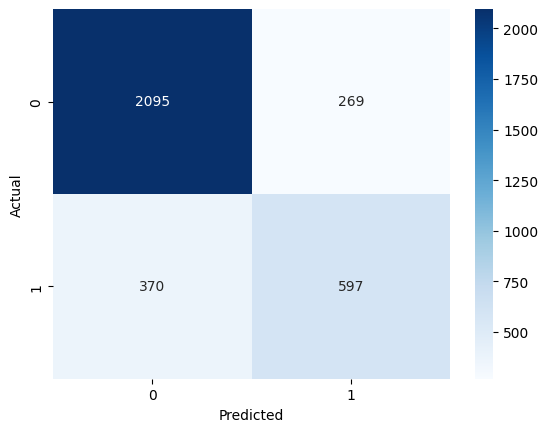

In [235]:
lstm_pred = evaluate_model(lstm_model, x_test_pad, y_test, "LSTM Model")

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Bi-LSTM Model Evaluation:
Correct Prediction: 2667
Wrong Prediction: 664
Accuracy: 80.07%
Confusion Matrix:


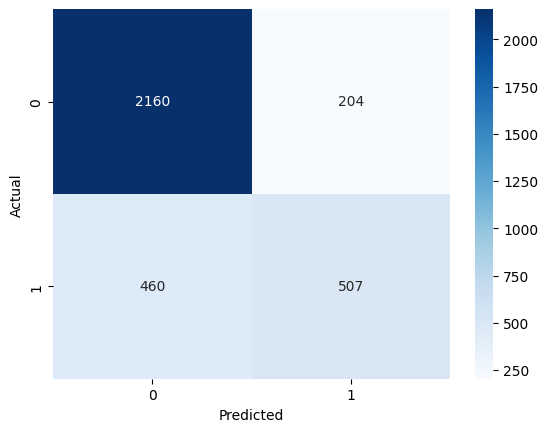

In [236]:
bilstm_pred = evaluate_model(bilstm_model, x_test_pad, y_test, "Bi-LSTM Model")

Plot Training History

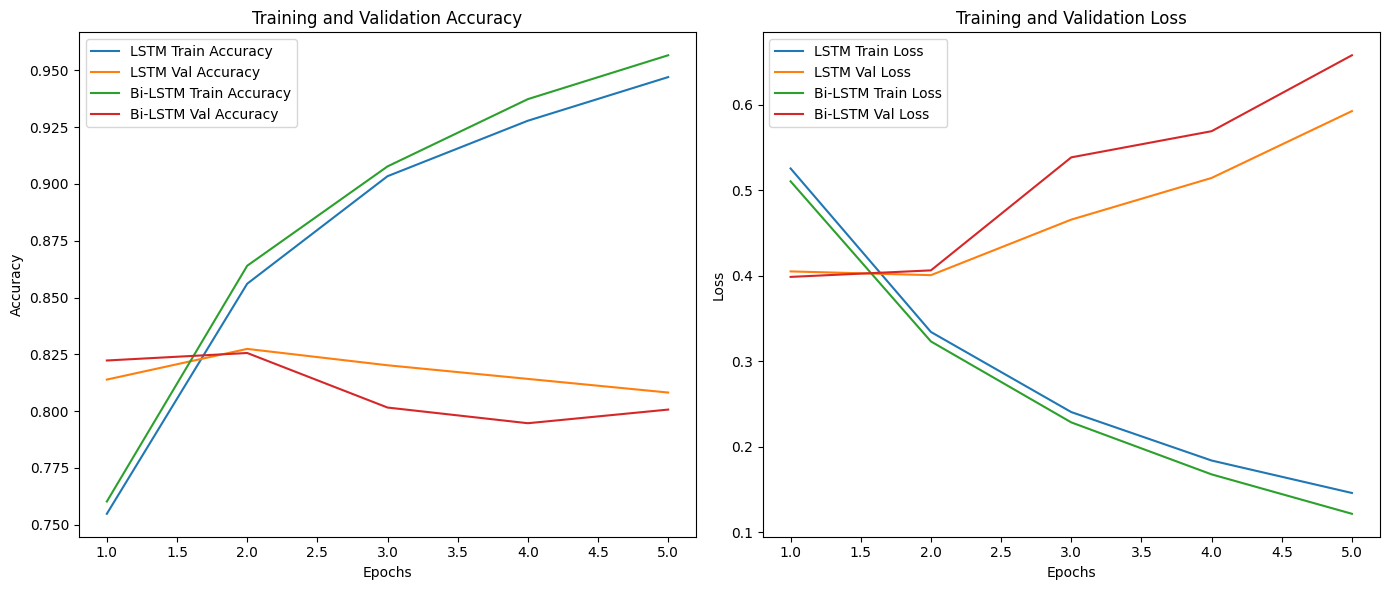

In [237]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(lstm_history, bilstm_history):
    epochs = range(1, len(lstm_history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, lstm_history.history['accuracy'], label='LSTM Train Accuracy')
    plt.plot(epochs, lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
    plt.plot(epochs, bilstm_history.history['accuracy'], label='Bi-LSTM Train Accuracy')
    plt.plot(epochs, bilstm_history.history['val_accuracy'], label='Bi-LSTM Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, lstm_history.history['loss'], label='LSTM Train Loss')
    plt.plot(epochs, lstm_history.history['val_loss'],  label='LSTM Val Loss')
    plt.plot(epochs, bilstm_history.history['loss'], label='Bi-LSTM Train Loss')
    plt.plot(epochs, bilstm_history.history['val_loss'], label='Bi-LSTM Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(lstm_history, bilstm_history)